In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

In [2]:
path = r'/home/lumin/nta.csv'
data = pd.read_csv(path)

In [3]:
data

,Bin centre (nm),Concentration (particles / ml),Concentration (particles / ml).1,Concentration (particles / ml).2,Concentration (particles / ml).3,Concentration (particles / ml).4,Concentration average,Standard Error
0,0.5,0,0,0,0,0,0,0
1,1.5,0,0,0,0,0,0,0
2,2.5,0,0,0,0,0,0,0
3,3.5,0,0,0,0,0,0,0
4,4.5,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
995,995.5,0,0,0,0,0,0,0
996,996.5,0,0,0,0,0,0,0
997,997.5,0,0,0,0,0,0,0
998,998.5,0,0,0,0,0,0,0


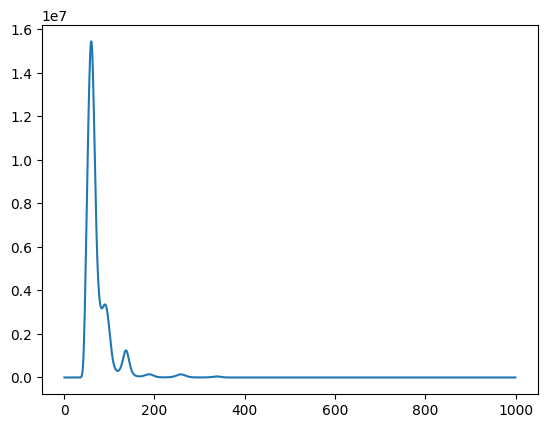

In [4]:
plt.plot(data['Bin centre (nm)'], data['Concentration (particles / ml)'])

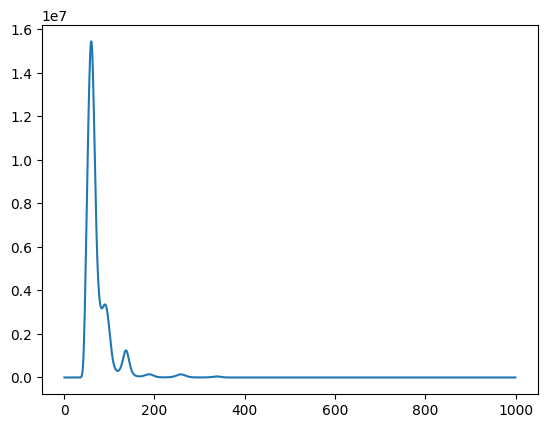

In [55]:
fig, ax1 = plt.subplots()
ax1.plot(data['Bin centre (nm)'], data['Concentration (particles / ml)'])
plt.show()

In [56]:
peaks = find_peaks(data['Concentration (particles / ml)'])

In [57]:
peaks

(array([ 59,  90, 136, 188, 258, 339]), {})

In [59]:
print(data['Bin centre (nm)'][59])

59.5


In [60]:
peaks_filtered = find_peaks(data['Concentration (particles / ml)'], height=(0.05*data['Concentration (particles / ml)'].max()))
peaks_filtered

(array([ 59,  90, 136]),
 {'peak_heights': array([15442426.,  3357367.,  1246941.])})

In [ ]:
x = data['Bin centre (nm)']
y = data['Concentration (particles / ml)']
for peak in peaks[0]:
    # plt.text(x[peak], y[peak], str(peak), fontsize=1)
    ax1.annotate(str(peak), (x[peak], y[peak]))
plt.show()

In [ ]:
x = data['Bin centre (nm)']
y = data['Concentration (particles / ml)']
for peak in peaks[0]:
    plt.text(x[peak], y[peak], str(peak), fontsize=1)
    # plt.annotate(str(peak), (x[peak], y[peak]))
plt.show()

In [45]:
peaks[0]

array([ 59,  90, 136, 188, 258, 339])

In [ ]:
x = data['Bin centre (nm)']
x[59]

In [ ]:
for peak in peaks[0]:
    print(type(peak))

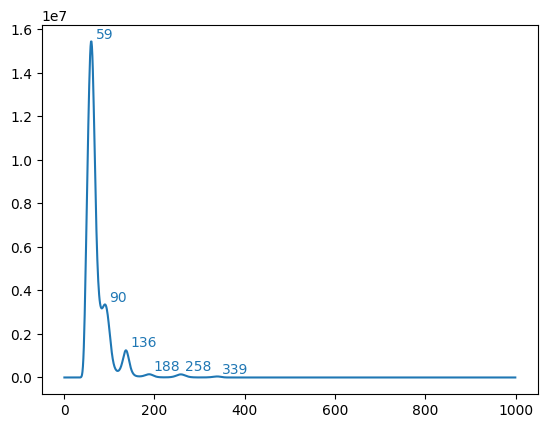

In [58]:
x = data['Bin centre (nm)']
y = data['Concentration (particles / ml)']
fig, ax1 = plt.subplots()
ax1.plot(x, y)
scale_x = 0.01*x.max()
scale_y = 0.01*y.max()
for peak in peaks[0]:
    ax1.annotate(str(peak), (x[peak]+scale_x, y[peak]+scale_y), color='#1f77b4')
plt.show()

In [3]:
import pandas as pd
import polars as pl
import numpy as np

In [48]:
def rejoining(tracks: pd.DataFrame, threshold_t: int,
              threshold_r: int) -> tuple[pd.DataFrame, int]:

    df_start = pd.DataFrame()
    df_end = pd.DataFrame()
    n_rejoined = 0
    temp_tracks = tracks.copy()

    # Get first and last point of each trajectory
    for item in set(tracks.particle):

        subtrack = tracks[tracks.particle == item]
        df_temp = subtrack[subtrack.frame == np.min(subtrack.frame)]
        df_start = pd.concat((df_start, df_temp), ignore_index=True)

        df_temp = subtrack[subtrack.frame == np.max(subtrack.frame)]
        df_end = pd.concat((df_end, df_temp), ignore_index=True)

    df_start = df_start.sort_values(by='frame', ascending=False)
    df_end = df_end.sort_values(by='frame', ascending=False)

    for linef in df_end.itertuples():
        for lined in df_start.itertuples():
            timed = lined.frame
            timef = linef.frame
            particle1 = linef.particle
            particle2 = lined.particle

            #Rejoins trajectories if they are within spatial and temporal range
            if (timed > timef) and (timed - timef < threshold_t):
                xd, yd = lined.x, lined.y
                xf, yf = linef.x, linef.y
                r = np.sqrt((xf-xd)**2 + (yf-yd)**2)
                if r < threshold_r and particle1 != particle2:

                    df_start.loc[df_start['particle'] == particle2,
                                 'particle'] = particle1
                    df_end.loc[df_end['particle'] == particle2,
                               'particle'] = particle1
                    temp_tracks.loc[temp_tracks['particle'] == particle2,
                                    'particle'] = particle1
                    df_start = df_start.loc[(df_start['frame'] != timed)
                                            & (df_start['particle'] != particle1)]
                    df_end = df_end.loc[(df_end['frame'] != timef)
                                        & (df_end['particle'] != particle1)]
                    n_rejoined += 1
                    break

    temp_tracks.rename(columns={'particle': 'rejoined_particle'}, inplace=True)
    tracks = tracks.reset_index(drop=True)
    temp_tracks = temp_tracks.reset_index(drop=True)
    tracks = pd.concat([tracks, temp_tracks['rejoined_particle']], axis=1, join='inner')

    return tracks, n_rejoined

In [65]:
def rejoining_polars(tracks: pl.DataFrame, threshold_t: int,
              threshold_r: int) -> tuple[pl.DataFrame, int]:

    df_start = pl.DataFrame()
    df_end = pl.DataFrame()
    n_rejoined = 0
    temp_tracks = tracks.clone()

    for traj in tracks.select(pl.col('particle').unique()).iter_rows():
        subtrack = tracks.filter(pl.col('particle') == traj)
        df_temp = subtrack.filter(pl.col('frame') == subtrack.select(pl.col('frame')).min())
        df_start = pl.concat([df_start, df_temp])

        df_temp = subtrack.filter(pl.col('frame') == subtrack.select(pl.col('frame')).max())
        df_end = pl.concat([df_end, df_temp])

    df_start = df_start.sort(pl.col('frame'), descending=True)
    df_end = df_end.sort(pl.col('frame'), descending=True)
    # Check order

    for linef in df_end.iter_rows(named=True):
        print(linef)
        for lined in df_start.iter_rows(named=True):
            timed = lined['frame']
            timef = linef['frame']
            particle1 = linef['particle']
            particle2 = lined['particle']

            if (timed > timef) and (timed - timef < threshold_t):
                xd, yd = lined.x, lined.y
                xf, yf = linef.x, linef.y
                r = np.sqrt((xf-xd)**2 + (yf-yd)**2)
                if r < threshold_r and particle1 != particle2:
                    df_start = df_start.filter(pl.col('particle') != particle2)
                    df_end = df_end.filter(pl.col('particle') != particle2)
                    temp_tracks = temp_tracks.filter(pl.col('particle') != particle2)
                    df_start = df_start.filter(pl.col('frame') != timed)
                    df_end = df_end.filter(pl.col('frame') != timef)
                    n_rejoined += 1
                    break
    print(temp_tracks.columns)
    temp_tracks.rename({'particle': 'rejoined_particle'})
    tracks = pl.concat([tracks, temp_tracks.select(pl.col('rejoined_particle'))])

    return tracks, n_rejoined

In [3]:
def rejoining_polars_better(tracks: pl.DataFrame, threshold_t: int,
              threshold_r: int) -> tuple[pl.DataFrame, int]:
    
    end = tracks.group_by('particle').agg(pl.col('frame').max())
    start = tracks.group_by('particle').agg(pl.col('frame').min())

    end = tracks.join(end, on=['particle', 'frame'],
                    how='inner').sort('frame', descending=True)
    start = tracks.join(start, on=['particle', 'frame'],
                    how='inner').sort('frame', descending=True)
    
    joined = end.select([pl.col('frame'), pl.col('x'), pl.col('y'), pl.col('particle')]).join(
        start.select([pl.col('frame'), pl.col('x'), pl.col('y'), pl.col('particle')]),
        on='frame', how='cross').with_columns(
            (pl.col('frame_right') - pl.col('frame')).alias('tdist')
    )
    
    joined = joined.with_columns(((pl.col('x') - pl.col('x_right'))**2 + (pl.col('y') - pl.col('y_right'))**2).sqrt().alias('rdist'))
    joined = joined.filter((pl.col('tdist') < threshold_t) & (pl.col('tdist') > 0) & (pl.col('rdist') < threshold_r))
    joined = joined.filter(pl.col('particle') != pl.col('particle_right'))

    n_rejoined = joined.select(pl.len()).item()

    tracks = tracks.with_columns(
        pl.when(pl.col('particle').is_in(joined.select('particle_right')))
        .then(joined.select('particle'))
        .otherwise(pl.col('particle'))
        .alias('rejoined_particle')
    )
    return tracks, n_rejoined
    

In [87]:
df = pl.read_csv(r'/media/lumin/DATA/Demo_BioProbe Results - 20240227_181856/Demo_BioProbe/Exp1_20190205_06_kif5a_nKTP/HET/larve3/oeil_droit/190205_nanoKTP_kif5a.lif - Series006.tif/190205_nanoKTP_kif5a.lif - Series006.tif_rejoined.csv', separator='\t')

In [17]:
len(df)

4053

In [88]:
df = df.drop('rejoined_particle')

In [ ]:
tracks, n_rejoined = rejoining_polars_better(df, 100, 400)

In [89]:
end = df.group_by('particle').agg(pl.col('frame').max())
start = df.group_by('particle').agg(pl.col('frame').min())

In [90]:
end = df.join(end, on=['particle', 'frame'],
                how='inner').sort('frame', descending=True)
start = df.join(start, on=['particle', 'frame'],
                how='inner').sort('frame', descending=True)

In [91]:
joined = end.select([pl.col('frame'), pl.col('x'), pl.col('y'), pl.col('particle')]).join(
        start.select([pl.col('frame'), pl.col('x'), pl.col('y'), pl.col('particle')]),
        on='frame', how='cross').with_columns(
            (pl.col('frame_right') - pl.col('frame')).alias('tdist')
    )

In [92]:
joined = joined.with_columns(((pl.col('x') - pl.col('x_right'))**2 + (pl.col('y') - pl.col('y_right'))**2).sqrt().alias('rdist'))
joined = joined.filter((pl.col('tdist') < 100) & (pl.col('tdist') > 0) & (pl.col('rdist') < 400))
joined = joined.filter(pl.col('particle') != pl.col('particle_right'))

In [94]:
joined = joined.sort(['tdist', 'rdist'])
joined = joined.unique(subset='particle_right')

In [95]:
joined

frame,x,y,particle,frame_right,x_right,y_right,particle_right,tdist,rdist
i64,f64,f64,i64,i64,f64,f64,i64,i64,f64
646,257.725344,127.663417,67,665,270.921687,128.52259,5606,19,13.224282


In [96]:
df = df.with_columns(df.get_column('particle').alias('rejoined_particle'))

In [97]:
df_with = df.join(joined.select(['particle_right']), left_on='particle', right_on='particle_right', how='semi')

In [98]:
df_without = df.join(joined.select(['particle_right']), left_on='particle', right_on='particle_right', how='anti')

In [ ]:
df_with = df_with.join(joined.select('particle'), left_on='rejoined_particle', right_on='particle', how='cross')
df_with

In [ ]:
df_with

In [101]:
df_with = df_with.with_columns(df_with.get_column('particle_right').alias('rejoined_particle'))

In [ ]:
df_with

In [ ]:
df_with = df_with.drop('particle_right')
df_with

In [104]:
merged_df = pl.concat([df_without, df_with], how='vertical')

In [69]:
merged_df

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,n_particles,n_static
i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,i64,i64
0,229.663939,283.397954,1955.0,1.977754,0.233723,207.0,1955.0,0.0,0,29,10.345836,73,81
1,229.538642,283.71897,2135.0,2.274592,0.167154,207.0,2135.0,0.0,1,29,10.345836,73,81
2,229.510138,284.151392,3699.0,2.387903,0.148729,234.0,3699.0,0.0,2,29,10.345836,73,81
3,230.049242,283.848485,1056.0,2.030543,0.355884,133.0,1056.0,0.0,3,29,10.345836,73,81
4,228.948768,283.964981,1542.0,1.917054,0.098045,133.0,1542.0,0.0,4,29,10.345836,73,81
5,228.958763,282.862371,1940.0,2.331872,0.145099,186.0,1940.0,0.0,5,29,10.345836,73,81
6,229.548523,282.998312,2370.0,2.072525,0.070842,234.0,2370.0,0.0,6,29,10.345836,73,81
7,229.676417,283.194394,1641.0,2.159118,0.186778,133.0,1641.0,0.0,7,29,10.345836,73,81
8,229.460915,283.323104,1727.0,2.321696,0.082195,186.0,1727.0,0.0,8,29,10.345836,73,81


In [105]:
merged_df = merged_df.sort('particle')

In [30]:
df2 = df.select('particle').join(merged_df.select('particle'), on='particle', how='left')

In [32]:
df2.unique()

particle
i64
45
46
67
29
5606
4823
10730


In [35]:
merged_df = df.join(joined.select("particle_right"), left_on='particle',
    right_on='particle_right', how='left')

In [39]:
merged_df = df.select('particle').join(joined.select("particle_right"), left_on='particle', right_on='particle_right', how='left')

In [ ]:
merged_df

In [36]:
len(merged_df)

4053

In [14]:
df = df.with_columns(
        pl.when(pl.col('particle').is_in(joined.select('particle_right')))
        .then(None)
        .otherwise(pl.col('particle'))
        .alias('rejoined_particle')
    )

In [15]:
df = df.with_columns(
        pl.when(pl.col('rejoined_particle').is_in(joined.select('particle_right')))
        .then(None)
        .otherwise(pl.col('particle'))
        .alias('rejoined_particle')
    )

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,n_particles,n_static,rejoined_particle
i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,i64,i64,i64
0,229.663939,283.397954,1955.0,1.977754,0.233723,207.0,1955.0,0.0,0,29,10.345836,73,81,29
1,229.538642,283.71897,2135.0,2.274592,0.167154,207.0,2135.0,0.0,1,29,10.345836,73,81,29
2,229.510138,284.151392,3699.0,2.387903,0.148729,234.0,3699.0,0.0,2,29,10.345836,73,81,29
3,230.049242,283.848485,1056.0,2.030543,0.355884,133.0,1056.0,0.0,3,29,10.345836,73,81,29
4,228.948768,283.964981,1542.0,1.917054,0.098045,133.0,1542.0,0.0,4,29,10.345836,73,81,29
5,228.958763,282.862371,1940.0,2.331872,0.145099,186.0,1940.0,0.0,5,29,10.345836,73,81,29
6,229.548523,282.998312,2370.0,2.072525,0.070842,234.0,2370.0,0.0,6,29,10.345836,73,81,29
7,229.676417,283.194394,1641.0,2.159118,0.186778,133.0,1641.0,0.0,7,29,10.345836,73,81,29
8,229.460915,283.323104,1727.0,2.321696,0.082195,186.0,1727.0,0.0,8,29,10.345836,73,81,29


In [ ]:
df = df.with_columns(
        pl.when(pl.col('particle').is_in(joined.select('particle_right')))
        .then(joined.select('particle_right'))
        .otherwise(pl.col('particle'))
        .alias('rejoined_particle')
    )

In [53]:
df = pd.read_csv(r'/media/lumin/DATA/190205_nanoKTP_kif5a.lif - Series031.tif.csv', sep='\t')
df.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd
0,0,35.121596,312.419253,1318.929412,2.517576,0.205943,185.435294,1328.0,0.0,0,0,0.220798
1,25,36.222052,312.407351,1306.000000,2.221984,0.171031,181.000000,1306.0,0.0,1,0,0.220798
2,46,36.450742,312.408907,1482.000000,2.352820,0.247184,186.000000,1482.0,0.0,2,0,0.220798
3,65,36.104594,313.000978,2046.000000,2.374103,0.072404,186.000000,2046.0,0.0,3,0,0.220798
4,83,36.423493,312.579598,1187.435294,2.411013,0.260376,132.141176,1196.0,0.0,4,0,0.220798


In [ ]:
tracks, n_rejoined = rejoining(df, 100, 400)

In [56]:
tracks.loc[tracks.rejoined_particle == 7]

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,rejoined_particle
5632,9,121.728440,447.266667,2731.411765,2.358147,0.018758,185.435294,2748.0,0.0,0,7,9.191418,7
5633,31,121.136727,448.513252,2377.000000,2.403020,0.058889,159.000000,2377.0,0.0,1,7,9.191418,7
5634,53,121.382133,447.353798,2541.000000,2.354795,0.104309,234.000000,2541.0,0.0,2,7,9.191418,7
5635,69,122.451238,447.085397,1979.000000,2.535349,0.165434,213.000000,1979.0,0.0,3,7,9.191418,7
5636,90,121.907204,446.599105,2254.658824,2.400736,0.132874,185.364706,2271.0,0.0,4,7,9.191418,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38825,32328,285.498721,192.585678,317.400000,2.533156,0.667519,79.552941,319.0,0.0,1509,3256,0.528759,7
38826,32349,289.532787,191.198770,396.141176,2.475702,0.427773,105.529412,398.0,0.0,1510,3256,0.528759,7
38827,32374,288.229979,188.759754,446.894118,2.424634,0.096823,105.529412,451.0,0.0,1511,3256,0.528759,7
38828,32395,290.188100,187.500960,422.929412,2.223155,0.096247,105.529412,425.0,0.0,1512,3256,0.528759,7


In [115]:
df = pl.read_csv(r'/media/lumin/DATA/190205_nanoKTP_kif5a.lif - Series031.tif.csv', separator='\t')

In [116]:
df = df.drop('rejoined_particle')

In [117]:
%%timeit
tracks, n_rejoined = rejoining_polars_better(df, 100, 400)

shape: (139_023, 10)
┌───────┬────────────┬────────────┬──────────┬───┬────────────┬───────────────┬───────┬────────────┐
│ frame ┆ x          ┆ y          ┆ particle ┆ … ┆ y_right    ┆ particle_righ ┆ tdist ┆ rdist      │
│ ---   ┆ ---        ┆ ---        ┆ ---      ┆   ┆ ---        ┆ t             ┆ ---   ┆ ---        │
│ i64   ┆ f64        ┆ f64        ┆ i64      ┆   ┆ f64        ┆ ---           ┆ i64   ┆ f64        │
│       ┆            ┆            ┆          ┆   ┆            ┆ i64           ┆       ┆            │
╞═══════╪════════════╪════════════╪══════════╪═══╪════════════╪═══════════════╪═══════╪════════════╡
│ 2510  ┆ 452.353333 ┆ 241.718889 ┆ 5362     ┆ … ┆ 238.814151 ┆ 5546          ┆ 1     ┆ 6.069019   │
│ 2510  ┆ 193.214932 ┆ 274.78733  ┆ 5535     ┆ … ┆ 238.814151 ┆ 5546          ┆ 1     ┆ 266.902491 │
│ 2510  ┆ 267.416887 ┆ 123.667546 ┆ 5540     ┆ … ┆ 238.814151 ┆ 5546          ┆ 1     ┆ 222.395105 │
│ 2509  ┆ 255.667712 ┆ 253.586207 ┆ 5411     ┆ … ┆ 238.814151 ┆ 5546  

Traceback (most recent call last):
  File "/home/lumin/.conda/envs/dev_mint/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_206792/3434582033.py", line 1, in <module>
    get_ipython().run_cell_magic('timeit', '', 'tracks, n_rejoined = rejoining_polars_better(df, 100, 400)\n')
  File "/home/lumin/.conda/envs/dev_mint/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2478, in run_cell_magic
    result = fn(*args, **kwargs)
  File "/home/lumin/.conda/envs/dev_mint/lib/python3.10/site-packages/IPython/core/magics/execution.py", line 1170, in timeit
    time_number = timer.timeit(number)
  File "/home/lumin/.conda/envs/dev_mint/lib/python3.10/site-packages/IPython/core/magics/execution.py", line 158, in timeit
    timing = self.inner(it, self.timer)
  File "<magic-timeit>", line 1, in inner
  File "/tmp/ipykernel_206792/4042776628.py", line 27, in rejoining

In [114]:
tracks.filter(pl.col('rejoined_particle')==7)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,n_particles,n_static,rejoined_particle
i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,i64,i64,i64
2466,121.72844,447.266667,2731.411765,2.358147,0.018758,185.435294,2748.0,0.0,0,7,9.191418,24,23,7
2467,121.136727,448.513252,2377.0,2.40302,0.058889,159.0,2377.0,0.0,1,7,9.191418,24,23,7
2468,121.382133,447.353798,2541.0,2.354795,0.104309,234.0,2541.0,0.0,2,7,9.191418,24,23,7
2469,122.451238,447.085397,1979.0,2.535349,0.165434,213.0,1979.0,0.0,3,7,9.191418,24,23,7
2470,121.907204,446.599105,2254.658824,2.400736,0.132874,185.364706,2271.0,0.0,4,7,9.191418,24,23,7
2471,122.22822,446.913415,1871.0,2.223123,0.352536,159.0,1871.0,0.0,5,7,9.191418,24,23,7
2472,122.064314,446.358642,2054.611765,2.489011,0.244055,212.894118,2071.0,0.0,6,7,9.191418,24,23,7
2473,122.177326,447.051962,2525.364706,2.337215,0.082999,212.894118,2540.0,0.0,7,7,9.191418,24,23,7
2474,121.935784,446.312223,2258.0,2.257161,0.221043,181.0,2258.0,0.0,8,7,9.191418,24,23,7


In [2]:
path = r'/media/lumin/DATA/rejoined.csv'
df = pd.read_csv(path, sep='\t')
df.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,rejoined_particle,n_particles,n_static
0,0,229.663939,283.397954,1955.0,1.977754,0.233723,207.0,1955.0,0.0,0,29,10.345836,29,73,81
1,1,229.538642,283.718970,2135.0,2.274592,0.167154,207.0,2135.0,0.0,1,29,10.345836,29,73,81
2,2,229.510138,284.151392,3699.0,2.387903,0.148729,234.0,3699.0,0.0,2,29,10.345836,29,73,81
3,3,230.049242,283.848485,1056.0,2.030543,0.355884,133.0,1056.0,0.0,3,29,10.345836,29,73,81
4,4,228.948768,283.964981,1542.0,1.917054,0.098045,133.0,1542.0,0.0,4,29,10.345836,29,73,81


In [3]:
df_start = pd.DataFrame()
df_end = pd.DataFrame()
n_rejoined = 0
temp_df = df.copy()

# Get first and last point of each trajectory
for item in set(df.particle):

    subtrack = df[df.particle == item]
    df_temp = subtrack[subtrack.frame == np.min(subtrack.frame)]
    df_start = pd.concat((df_start, df_temp), ignore_index=True)

    df_temp = subtrack[subtrack.frame == np.max(subtrack.frame)]
    df_end = pd.concat((df_end, df_temp), ignore_index=True)

df_start = df_start.sort_values(by='frame', ascending=False)
df_end = df_end.sort_values(by='frame', ascending=False)

In [52]:
df_start

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,rejoined_particle,n_particles,n_static
2,3661,221.221267,250.785068,2210.0,2.209195,0.072827,186.0,2210.0,0.0,1316,10730,133.599992,10730,73,81
1,3445,128.522590,270.921687,664.0,2.591401,0.371132,80.0,664.0,0.0,665,5606,65.260578,67,73,81
5,3439,81.751174,311.563380,426.0,2.658144,0.143711,133.0,426.0,0.0,583,4823,9.879985,4823,73,81
0,2819,122.094007,227.655699,851.0,2.398345,0.773631,133.0,851.0,0.0,0,67,31.277308,67,73,81
3,396,302.815832,102.181745,3714.0,2.359515,0.146294,234.0,3714.0,0.0,0,45,230.003124,45,73,81
4,1054,321.297800,266.491881,3818.0,2.446012,0.144065,234.0,3818.0,0.0,0,46,28.128372,46,73,81
6,0,229.663939,283.397954,1955.0,1.977754,0.233723,207.0,1955.0,0.0,0,29,10.345836,29,73,81


In [48]:
df_end

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,rejoined_particle,n_particles,n_static
2,4052,205.874807,183.584544,3235.0,2.482022,0.135423,207.0,3235.0,0.0,1764,10730,133.599992,10730,73,81
4,2818,320.121072,236.756990,3469.0,2.396728,0.108906,234.0,3469.0,0.0,1764,46,28.128372,46,73,81
1,3660,133.555701,318.111402,763.0,2.081876,0.154434,159.0,763.0,0.0,888,5606,65.260578,67,73,81
3,1053,345.735178,182.318182,506.0,2.405938,0.330849,80.0,506.0,0.0,679,45,230.003124,45,73,81
0,3438,127.663417,257.725344,1744.0,2.209757,0.111411,207.0,1744.0,0.0,646,67,31.277308,67,73,81
5,3444,94.135678,328.000000,398.0,1.862079,0.343871,80.0,398.0,0.0,592,4823,9.879985,4823,73,81
6,395,222.236726,266.646018,452.0,1.971590,0.505435,80.0,452.0,0.0,427,29,10.345836,29,73,81


In [30]:
pdf = pl.read_csv(path, separator='\t')

In [31]:
pdf_end = pdf.group_by('particle').agg(pl.col('frame').max())
pdf_start = pdf.group_by('particle').agg(pl.col('frame').min())

In [32]:
pdf_end

particle,frame
i64,i64
4823,592
45,679
46,1764
5606,888
10730,1764
29,427
67,646


In [33]:
pdf_end = pdf.join(pdf_end, on=['particle', 'frame'],
                    how='inner').sort('frame', descending=True)
pdf_start = pdf.join(pdf_start, on=['particle', 'frame'],
                    how='inner').sort('frame', descending=True)

In [34]:
pdf_end

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,rejoined_particle,n_particles,n_static
i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,i64,i64,i64
2818,320.121072,236.75699,3469.0,2.396728,0.108906,234.0,3469.0,0.0,1764,46,28.128372,46,73,81
4052,205.874807,183.584544,3235.0,2.482022,0.135423,207.0,3235.0,0.0,1764,10730,133.599992,10730,73,81
3660,133.555701,318.111402,763.0,2.081876,0.154434,159.0,763.0,0.0,888,5606,65.260578,67,73,81
1053,345.735178,182.318182,506.0,2.405938,0.330849,80.0,506.0,0.0,679,45,230.003124,45,73,81
3438,127.663417,257.725344,1744.0,2.209757,0.111411,207.0,1744.0,0.0,646,67,31.277308,67,73,81
3444,94.135678,328.0,398.0,1.862079,0.343871,80.0,398.0,0.0,592,4823,9.879985,4823,73,81
395,222.236726,266.646018,452.0,1.97159,0.505435,80.0,452.0,0.0,427,29,10.345836,29,73,81


In [14]:
end_f = pdf_end.select([pl.col('frame'), pl.col('x'), pl.col('y')])
start_f = pdf_start.select([pl.col('frame'), pl.col('x'), pl.col('y')])
frames_joined = end_f.join(start_f, on='frame', how='cross')

In [35]:
joined = pdf_end.select([pl.col('frame'), pl.col('x'), pl.col('y'), pl.col('particle')]).join(
        pdf_start.select([pl.col('frame'), pl.col('x'), pl.col('y'), pl.col('particle')]),
        on='frame', how='cross').with_columns(
            (pl.col('frame') - pl.col('frame_right')).alias('tdist')
    )
joined

frame,x,y,particle,frame_right,x_right,y_right,particle_right,tdist
i64,f64,f64,i64,i64,f64,f64,i64,i64
1764,236.75699,320.121072,46,1316,250.785068,221.221267,10730,448
1764,236.75699,320.121072,46,665,270.921687,128.52259,5606,1099
1764,236.75699,320.121072,46,583,311.56338,81.751174,4823,1181
1764,236.75699,320.121072,46,0,283.397954,229.663939,29,1764
1764,236.75699,320.121072,46,0,102.181745,302.815832,45,1764
1764,236.75699,320.121072,46,0,266.491881,321.2978,46,1764
1764,236.75699,320.121072,46,0,227.655699,122.094007,67,1764
1764,183.584544,205.874807,10730,1316,250.785068,221.221267,10730,448
1764,183.584544,205.874807,10730,665,270.921687,128.52259,5606,1099


In [36]:
joined.filter((pl.col('tdist') < 10) & (pl.col('tdist') > 0))

frame,x,y,particle,frame_right,x_right,y_right,particle_right,tdist
i64,f64,f64,i64,i64,f64,f64,i64,i64
592,328.0,94.135678,4823,583,311.56338,81.751174,4823,9


In [21]:
def dist(row):
    xf = pl.col('x')
    xd = pl.col('x_right')
    yf = pl.col('y')
    yd = pl.col('y_right')
    return np.sqrt((xf-xd)**2 + (yf-yd)**2)

In [40]:
joined = joined.with_columns(((pl.col('x') - pl.col('x_right'))**2 + (pl.col('y') - pl.col('y_right'))**2).sqrt().alias('rdist'))
joined = joined.filter((pl.col('tdist') < 10) & (pl.col('tdist') > 0) & (pl.col('rdist') < 25))

In [41]:
joined

frame,x,y,particle,frame_right,x_right,y_right,particle_right,tdist,rdist
i64,f64,f64,i64,i64,f64,f64,i64,i64,f64
592,328.0,94.135678,4823,583,311.56338,81.751174,4823,9,20.580049


In [51]:
joined.select(pl.count()).item()

/tmp/ipykernel_206792/2423647146.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  joined.select(pl.count()).item()


1

In [43]:
pdf.filter(pl.col('particle') == joined.select('particle'))

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,rejoined_particle,n_particles,n_static
i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,i64,i64,i64
3439,81.751174,311.56338,426.0,2.658144,0.143711,133.0,426.0,0.0,583,4823,9.879985,4823,73,81
3440,86.332953,313.147092,877.0,2.569668,0.357129,106.0,877.0,0.0,584,4823,9.879985,4823,73,81
3441,84.846599,317.539797,691.0,2.267878,0.176165,160.0,691.0,0.0,585,4823,9.879985,4823,73,81
3442,87.932331,322.533835,399.0,2.221449,0.274266,80.0,399.0,0.0,588,4823,9.879985,4823,73,81
3443,91.435294,326.936471,425.0,2.78272,0.547875,80.0,425.0,0.0,589,4823,9.879985,4823,73,81
3444,94.135678,328.0,398.0,1.862079,0.343871,80.0,398.0,0.0,592,4823,9.879985,4823,73,81


In [39]:
joined.filter(pl.col('particle') != pl.col('particle_right'))

frame,x,y,particle,frame_right,x_right,y_right,particle_right,tdist,rdist
i64,f64,f64,i64,i64,f64,f64,i64,i64,f64


In [45]:
joined.select('particle')

particle
i64
4823


In [44]:
pdf = pdf.drop('rejoined_particle')

In [46]:
pdf = pdf.with_columns(
    pl.when(pl.col('particle').is_in(joined.select('particle')))
    .then(joined.select('particle'))
    .otherwise(pl.col('particle'))
    .alias('rejoined_particle')
)

In [47]:
pdf

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,n_particles,n_static,rejoined_particle
i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,i64,i64,i64
0,229.663939,283.397954,1955.0,1.977754,0.233723,207.0,1955.0,0.0,0,29,10.345836,73,81,29
1,229.538642,283.71897,2135.0,2.274592,0.167154,207.0,2135.0,0.0,1,29,10.345836,73,81,29
2,229.510138,284.151392,3699.0,2.387903,0.148729,234.0,3699.0,0.0,2,29,10.345836,73,81,29
3,230.049242,283.848485,1056.0,2.030543,0.355884,133.0,1056.0,0.0,3,29,10.345836,73,81,29
4,228.948768,283.964981,1542.0,1.917054,0.098045,133.0,1542.0,0.0,4,29,10.345836,73,81,29
5,228.958763,282.862371,1940.0,2.331872,0.145099,186.0,1940.0,0.0,5,29,10.345836,73,81,29
6,229.548523,282.998312,2370.0,2.072525,0.070842,234.0,2370.0,0.0,6,29,10.345836,73,81,29
7,229.676417,283.194394,1641.0,2.159118,0.186778,133.0,1641.0,0.0,7,29,10.345836,73,81,29
8,229.460915,283.323104,1727.0,2.321696,0.082195,186.0,1727.0,0.0,8,29,10.345836,73,81,29


In [4]:
path = r'/home/lumin/test_nta.csv'

In [5]:
with open(path, 'r') as temp_f:
    # get No of columns in each line
    col_count = [len(line.split(",")) for line in temp_f.readlines()]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]

### Read csv
df = pd.read_csv(path, header=None, delimiter=",", names=column_names)

In [75]:
df

,0,1,2,3,4,5,6,7,8
0,NTA Experiment Summary File,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Created with NTA 3.4 - Sample Assistant Build ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[Experiment Details],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Software Version,NTA 3.4 - Sample Assistant Build 3.4.4 - SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1183,97,144.4,171.8,120.5,126.2,136.7,NaN,NaN,NaN
1184,98,164.9,176.8,152.2,192.4,222.0,NaN,NaN,NaN
1185,99,245.4,183.4,168.2,257.5,267.3,NaN,NaN,NaN
1186,100,375.0,416.0,429.0,381.0,359.0,NaN,NaN,NaN


In [11]:
df.columns = [str(cn) for cn in df.columns]
df.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8'], dtype='object')

In [12]:
start = (df[df['0'] == 'Bin centre (nm)']).index[0]
end = (df[df['0'] == 'Percentile']).index[0]

In [106]:
vals = df.iloc[start:end]
vals

,0,1,2,3,4,5,6,7,8
84,Bin centre (nm),Concentration (particles / ml),Concentration (particles / ml),Concentration (particles / ml),Concentration (particles / ml),Concentration (particles / ml),Concentration average,Standard Error,NaN
85,0.5,0,0,0,0,0,0,0,NaN
86,1.5,0,0,0,0,0,0,0,NaN
87,2.5,0,0,0,0,0,0,0,NaN
88,3.5,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...
1080,995.5,0,0,0,0,0,0,0,NaN
1081,996.5,0,0,0,0,0,0,0,NaN
1082,997.5,0,0,0,0,0,0,0,NaN
1083,998.5,0,0,0,0,0,0,0,NaN


In [107]:
vals.columns = vals.iloc[0]

In [108]:
vals = vals.iloc[1:]

In [95]:
vals

84,Bin centre (nm),Concentration (particles / ml),Concentration (particles / ml),Concentration (particles / ml),Concentration (particles / ml),Concentration (particles / ml),Concentration average,Standard Error,NaN
85,0.5,0,0,0,0,0,0,0,NaN
86,1.5,0,0,0,0,0,0,0,NaN
87,2.5,0,0,0,0,0,0,0,NaN
88,3.5,0,0,0,0,0,0,0,NaN
89,4.5,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...
1080,995.5,0,0,0,0,0,0,0,NaN
1081,996.5,0,0,0,0,0,0,0,NaN
1082,997.5,0,0,0,0,0,0,0,NaN
1083,998.5,0,0,0,0,0,0,0,NaN


In [115]:
new_labels = []
for i, col in enumerate(vals.columns):
    if col == 'Concentration (particles / ml)':
        col = f'{col} #{i}'
    new_labels.append(col)

vals.columns = new_labels
vals

,Bin centre (nm),Concentration (particles / ml) #1,Concentration (particles / ml) #2,Concentration (particles / ml) #3,Concentration (particles / ml) #4,Concentration (particles / ml) #5,Concentration average,Standard Error,NaN
85,0.5,0,0,0,0,0,0,0,NaN
86,1.5,0,0,0,0,0,0,0,NaN
87,2.5,0,0,0,0,0,0,0,NaN
88,3.5,0,0,0,0,0,0,0,NaN
89,4.5,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...
1080,995.5,0,0,0,0,0,0,0,NaN
1081,996.5,0,0,0,0,0,0,0,NaN
1082,997.5,0,0,0,0,0,0,0,NaN
1083,998.5,0,0,0,0,0,0,0,NaN


In [119]:
vals['Bin centre (nm)'].iloc[456]

'456.5'

In [124]:
vals = vals.apply(pd.to_numeric)

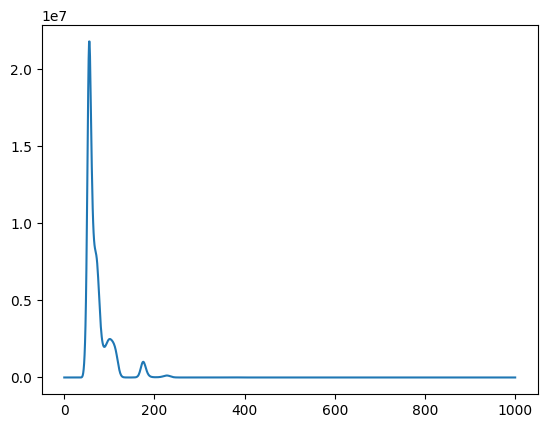

In [125]:
plt.plot(vals['Bin centre (nm)'], vals['Concentration (particles / ml) #2'])

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

def load_nta(path):

    with open(path, 'r') as temp_f:
        col_count = [len(line.split(",")) for line in temp_f.readlines()]

    column_names = [i for i in range(0, max(col_count))]

    df = pd.read_csv(path, header=None, delimiter=",", names=column_names)

    df.columns = [str(cn) for cn in df.columns]

    start = (df[df['0'] == 'Bin centre (nm)']).index[0]
    end = (df[df['0'] == 'Percentile']).index[0]

    vals = df.iloc[start:end]
    vals.columns = vals.iloc[0]
    vals = vals.iloc[1:]

    new_labels = []
    for i, col in enumerate(vals.columns):
        if col == 'Concentration (particles / ml)':
            col = f'{col} #{i}'
        new_labels.append(col)

    vals.columns = new_labels
    vals = vals.apply(pd.to_numeric)
    vals.reset_index(inplace=True)

    return vals

def plot_nta(data):

    x = data['Bin centre (nm)']
    y = data['Concentration average']
    fig, ax1 = plt.subplots()
    ax1.plot(x, y)
    scale_x = 0.01*x.max()
    scale_y = 0.01*y.max()
    peaks = find_peaks(y) # height=(0.05*y.max())
    for peak in peaks[0][:3]:
        ax1.annotate(str(peak), (x[peak]+scale_x, y[peak]+scale_y), color='#1f77b4')
    plt.show()



In [ ]:
data = load_nta(r'/home/lumin/test_nta.csv')
plot_nta(data)

In [ ]:
path = r'/media/lumin/DATA/NTA/20240215/FND40MAL_1microgml 2024-02-15 11-54-25-ExperimentSummary.csv'
data = load_nta(path)
plot_nta(data)

In [29]:
pre = load_nta(r'/media/lumin/DATA/NTA/20240215/FND40MAL_1microgml 2024-02-15 11-54-25-ExperimentSummary.csv')
post = load_nta(r'/media/lumin/DATA/NTA/20240215/FND40RVG29C 2024-02-15 12-40-27-ExperimentSummary.csv')
sn = load_nta(r'/media/lumin/DATA/NTA/20240215/FND40MAL_SN0 2024-02-15 15-09-32-ExperimentSummary.csv')
sn1 = load_nta(r'/media/lumin/DATA/NTA/20240215/FND40MAL_SN1 2024-02-15 15-54-06-ExperimentSummary.csv')

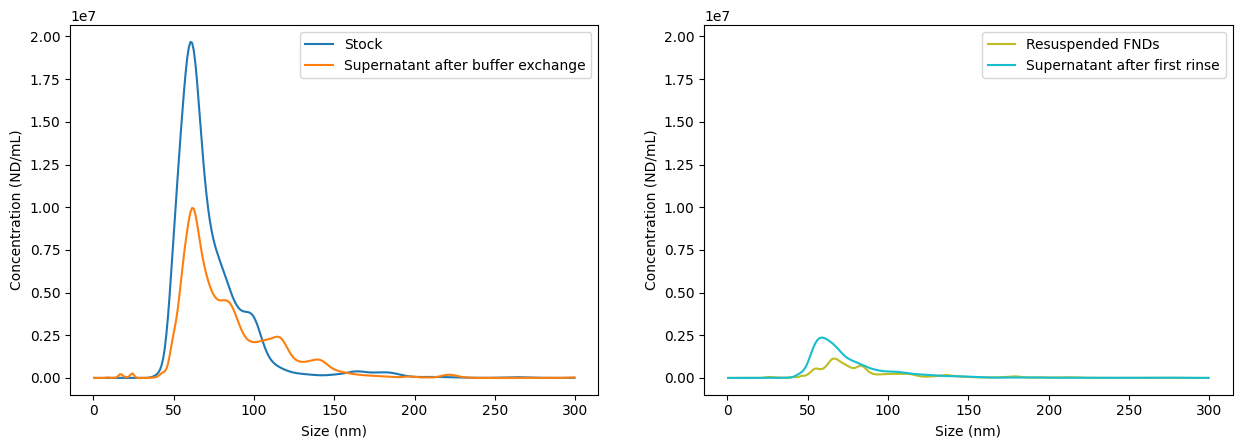

In [38]:
xpre = pre['Bin centre (nm)'][:300]
ypre = pre['Concentration average'][:300]
xpost = post['Bin centre (nm)'][:300]
ypost = post['Concentration average'][:300]
xsn = sn['Bin centre (nm)'][:300]
ysn = sn['Concentration average'][:300] * 5
xsn1 = sn1['Bin centre (nm)'][:300]
ysn1 = sn1['Concentration average'][:300]
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set(size_inches=[15, 4.8])
ax1.plot(xpre, ypre)
ax1.plot(xsn, ysn)
ax2.plot(xpost, ypost, c='#bcbd22')
ax2.plot(xsn1, ysn1, c='#17becf')
ax1.legend(['Stock', 'Supernatant after buffer exchange'])
ax2.legend(['Resuspended FNDs', 'Supernatant after first rinse'])
ax1.set_xlabel('Size (nm)')
ax1.set_ylabel('Concentration (ND/mL)')
ax2.set_xlabel('Size (nm)')
ax2.set_ylabel('Concentration (ND/mL)')
ax2.yaxis.set_tick_params(labelleft=True)
# scale_x = 0.01*x.max()
# scale_y = 0.01*y.max()
# peaks = find_peaks(y) # height=(0.05*y.max())
# for peak in peaks[0][:3]:
#     ax1.annotate(str(peak), (x[peak]+scale_x, y[peak]+scale_y), color='#1f77b4')
# plt.show()
plt.savefig(r'/home/lumin/NTA.png', dpi=300)


In [21]:
area_pre = np.trapz(ypre, dx=1)
area_pre

568227580.0

In [23]:
area_sn = np.trapz(ysn, dx=1)
area_sn

359346455.0

In [34]:
area_post = np.trapz(ypost, dx=1)
area_post

40701125.0

In [1]:
from imageio import volread
from mint.denoising import filtering, array_filtering, filtering_p
import matplotlib.pyplot as plt
import numpy as np

In [3]:
frames = volread(r'/media/lumin/DATA/Demo_BioProbe/Exp1_20190205_06_kif5a_nKTP/HET/larve3/oeil_gauche/190205_nanoKTP_kif5a.lif - Series003.tif')

In [4]:
frames = frames.astype('float64')

In [12]:
frames.shape

(1765, 350, 512)

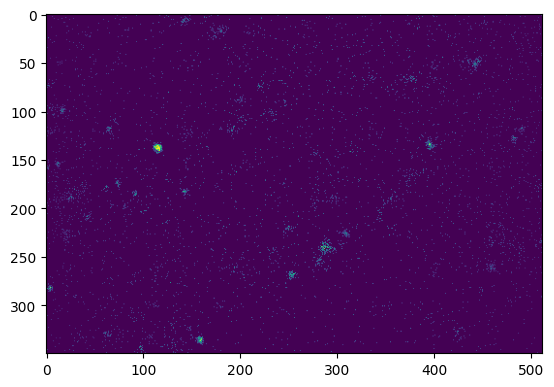

In [5]:
plt.imshow(frames[0])

In [6]:
p = {'separation':12}
s = {'tophat':True, 'wavelet':False}

In [7]:
f1 = filtering(frames, s, p)

In [8]:
f2 = array_filtering(frames, s, p)

In [9]:
f3 = filtering_p(frames, s, p)

In [11]:
np.array_equal(f3, f2)

True

In [25]:
%%timeit 
th1 = tophat(12, frames[0])

932 µs ± 2.99 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [26]:
%%timeit 
th2 = tophat2(12, frames[0])

82.4 µs ± 141 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [3]:
type(np.empty(0))

numpy.ndarray

In [5]:
ar = 'qd'
opts = ['antero', 'retro']

In [7]:
if ar not in opts:
    print(ar)

qd


In [14]:
ar = 'Antero'
if ar is True:
    print(ar)
else:
    print('None')

None


In [16]:
if ar is True:
    print('ok')

In [17]:
if ar:
    print('ok')

ok


In [18]:
ar = ''
if not ar:
    print('ok')

ok


# Test rejoining

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [71]:
tracks = pd.read_csv(r'/media/lumin/DATA/2rej.csv', sep='\t')

In [72]:
tracks.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,rejoined_particle,n_particles,n_static
0,0,59.998433,287.125392,638.0,2.473369,0.106974,133.0,638.0,0.0,922,9096,26.873064,9096,82,82
1,1,60.381323,286.485084,771.0,2.558524,0.147608,133.0,771.0,0.0,923,9096,26.873064,9096,82,82
2,2,60.300792,286.694811,1137.0,2.139999,0.189680,186.0,1137.0,0.0,924,9096,26.873064,9096,82,82
3,3,61.027254,286.788959,1431.0,2.322527,0.214723,133.0,1431.0,0.0,925,9096,26.873064,9096,82,82
4,4,60.230101,286.073806,691.0,1.922522,0.638846,159.0,691.0,0.0,926,9096,26.873064,9096,82,82


In [ ]:
for item in tracks.rejoined_particle.unique(): # Loop for each sub trajectory
        x = tracks[tracks.rejoined_particle == item].x
        y = tracks[tracks.rejoined_particle == item].y
        plt.plot(x, y)
plt.show()

In [4]:
df_start = pd.DataFrame()
df_end = pd.DataFrame()
n_rejoined = 0
temp_tracks = tracks.copy()

# Get first and last point of each trajectory
for item in set(tracks.particle):

    subtrack = tracks[tracks.particle == item]
    df_temp = subtrack[subtrack.frame == np.min(subtrack.frame)]
    df_start = pd.concat((df_start, df_temp), ignore_index=True)

    df_temp = subtrack[subtrack.frame == np.max(subtrack.frame)]
    df_end = pd.concat((df_end, df_temp), ignore_index=True)

df_start = df_start.sort_values(by='frame', ascending=False)
df_end = df_end.sort_values(by='frame', ascending=False)

In [ ]:
for linef in df_end.itertuples():
    for lined in df_start.itertuples():
        print(type(lined.x))
        timed = lined.frame
        timef = linef.frame

print(timed, timef)

In [74]:
def rejoining(tracks: pd.DataFrame, threshold_t: int,
              threshold_r: int) -> tuple[pd.DataFrame, int]:

    df_start = pd.DataFrame()
    df_end = pd.DataFrame()
    n_rejoined = 0
    temp_tracks = tracks.copy()

    # Get first and last point of each trajectory
    for item in set(tracks.particle):

        subtrack = tracks[tracks.particle == item]
        df_temp = subtrack[subtrack.frame == np.min(subtrack.frame)]
        df_start = pd.concat((df_start, df_temp), ignore_index=True)

        df_temp = subtrack[subtrack.frame == np.max(subtrack.frame)]
        df_end = pd.concat((df_end, df_temp), ignore_index=True)

    df_start = df_start.sort_values(by='frame', ascending=False)
    df_end = df_end.sort_values(by='frame', ascending=False)

    for linef in df_end.itertuples():
        for lined in df_start.itertuples():
            timed = int(lined.frame)
            timef = int(linef.frame)
            particle1 = linef.particle
            particle2 = lined.particle

            #Rejoins trajectories if they are within spatial and temporal range
            if (timed > timef) and (timed - timef < threshold_t):
                xd, yd = lined.x, lined.y
                xf, yf = linef.x, linef.y
                r = np.sqrt((xf-xd)**2 + (yf-yd)**2)
                if r < threshold_r and particle1 != particle2:

                    df_start.loc[df_start['particle'] == particle2,
                                 'particle'] = particle1
                    df_end.loc[df_end['particle'] == particle2,
                               'particle'] = particle1
                    temp_tracks.loc[temp_tracks['particle'] == particle2,
                                    'particle'] = particle1
                    df_start = df_start.loc[(df_start['frame'] != timed)
                                            & (df_start['particle'] != particle1)]
                    df_end = df_end.loc[(df_end['frame'] != timef)
                                        & (df_end['particle'] != particle1)]
                    n_rejoined += 1
                    break

    temp_tracks.rename(columns={'particle': 'rejoined_particle'}, inplace=True)
    tracks = tracks.reset_index(drop=True)
    temp_tracks = temp_tracks.reset_index(drop=True)
    tracks = pd.concat([tracks, temp_tracks['rejoined_particle']], axis=1, join='inner')

    return tracks, n_rejoined

In [ ]:
def rejoining_polars(tracks: pl.DataFrame, threshold_t: int,
              threshold_r: int) -> tuple[pl.DataFrame, int]:

    if isinstance(tracks, pd.DataFrame):
        tracks = pl.from_pandas(tracks)

    end = tracks.group_by('particle').agg(pl.col('frame').max())
    start = tracks.group_by('particle').agg(pl.col('frame').min())

    end = tracks.join(end, on=['particle', 'frame'],
                    how='inner').sort('frame', descending=True)
    start = tracks.join(start, on=['particle', 'frame'],
                    how='inner').sort('frame', descending=True)

    joined = end.select([pl.col('frame'), pl.col('x'), pl.col('y'), pl.col('particle')]
                        ).join(
        start.select([pl.col('frame'), pl.col('x'), pl.col('y'), pl.col('particle')]),
        on='frame', how='cross').with_columns(
            (pl.col('frame_right') - pl.col('frame')).alias('tdist')
    )

    joined = joined.with_columns(((pl.col('x') - pl.col('x_right'))**2 + (pl.col('y')
                                    - pl.col('y_right'))**2).sqrt().alias('rdist'))
    joined = joined.filter((pl.col('tdist') < threshold_t) & (pl.col('tdist') > 0)
                           & (pl.col('rdist') < threshold_r))
    joined = joined.filter(pl.col('particle') != pl.col('particle_right'))
    joined = joined.sort(['tdist', 'rdist'])
    joined = joined.unique(subset='particle_right')

    n_rejoined = joined.select(pl.len()).item()

    tracks = tracks.with_columns(tracks.get_column('particle')
                                 .alias('rejoined_particle'))

    df_with = tracks.join(joined.select(['particle_right']), left_on='particle',
                          right_on='particle_right', how='semi')

    df_without = tracks.join(joined.select(['particle_right']), left_on='particle',
                             right_on='particle_right', how='anti')

    df_with = df_with.join(joined.select('particle'), left_on='rejoined_particle',
                           right_on='particle', how='cross')

    df_with = df_with.with_columns(df_with.get_column('particle_right')
                                   .alias('rejoined_particle'))

    df_with = df_with.drop('particle_right')

    tracks = pl.concat([df_without, df_with], how='vertical')

    # tracks = tracks.with_columns(
    #     pl.when((pl.col('particle').is_in(joined.select('particle_right')))
    #             & (joined.count() > 0))
    #     .then(joined.select('particle'))
    #     .otherwise(pl.col('particle'))
    #     .alias('rejoined_particle')
    # )

    tracks = tracks.to_pandas()

In [21]:
tracks = tracks.drop('rejoined_particle', axis=1)
tracks, nrej = rejoining(tracks, 100, 400)

In [ ]:
tracks.head()

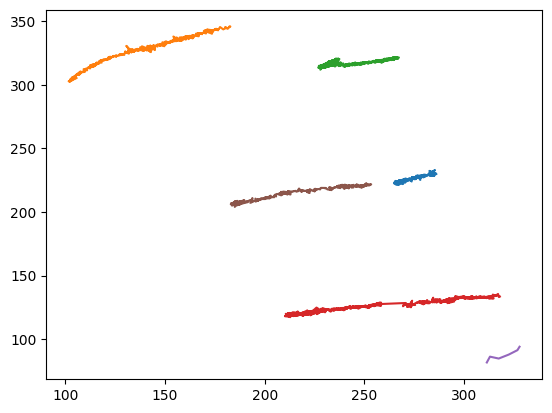

In [38]:
for item in tracks.rejoined_particle.unique(): # Loop for each sub trajectory
        x = tracks[tracks.rejoined_particle == item].x
        y = tracks[tracks.rejoined_particle == item].y
        plt.plot(x, y)
plt.show()

In [75]:
tracks = tracks.drop('rejoined_particle', axis=1)

In [76]:
tracks.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,n_particles,n_static
0,0,59.998433,287.125392,638.0,2.473369,0.106974,133.0,638.0,0.0,922,9096,26.873064,82,82
1,1,60.381323,286.485084,771.0,2.558524,0.147608,133.0,771.0,0.0,923,9096,26.873064,82,82
2,2,60.300792,286.694811,1137.0,2.139999,0.189680,186.0,1137.0,0.0,924,9096,26.873064,82,82
3,3,61.027254,286.788959,1431.0,2.322527,0.214723,133.0,1431.0,0.0,925,9096,26.873064,82,82
4,4,60.230101,286.073806,691.0,1.922522,0.638846,159.0,691.0,0.0,926,9096,26.873064,82,82


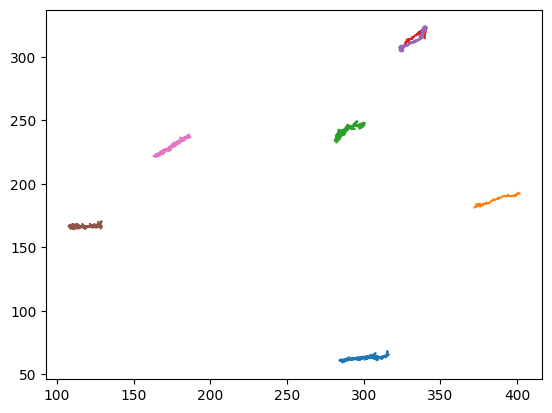

In [77]:
for item in tracks.particle.unique(): # Loop for each sub trajectory
        x = tracks[tracks.particle == item].x
        y = tracks[tracks.particle == item].y
        plt.plot(x, y)
plt.show()

In [26]:
def rejoining_2(tracks: pd.DataFrame, threshold_t: int,
              threshold_r: int) -> tuple[pd.DataFrame, int]:

    df_start = tracks.groupby(by="particle").agg(
        {'frame': 'min'}).sort_values(by='frame', ascending=False)
    df_end = tracks.groupby(by="particle").agg(
        {'frame': 'max'}).sort_values(by='frame', ascending=False)

    tstart = tracks.merge(df_start, on=['frame', 'particle'], how='right')
    tend = tracks.merge(df_end, on=['frame', 'particle'], how='right')

    joined = tend[['x', 'y', 'frame', 'particle']
                  ].merge(tstart[['x', 'y', 'frame', 'particle']], how='cross')

    joined['r_dist'] = np.sqrt((joined.x_x - joined.x_y)**2 +
                               (joined.y_x - joined.y_y)**2)
    joined['t_dist'] = joined.frame_y - joined.frame_x

    filtered = joined.loc[(joined.t_dist > 0) & (joined.t_dist < threshold_t)]
    filtered = filtered.loc[joined.r_dist < threshold_r]
    filtered = filtered.sort_values(by=['t_dist', 'r_dist'])
    filtered = filtered.drop_duplicates('particle_y')

    n_rejoined = len(filtered)

    tracks['rejoined_particle'] = tracks.particle
    merged = tracks.merge(filtered['particle_x'], left_on='rejoined_particle',
                          right_on='particle_x', how='left')
    merged = merged.drop('particle_x', axis=1)

    return merged, n_rejoined

In [59]:
def rejoining_3(tracks: pd.DataFrame, threshold_t: int,
              threshold_r: int) -> tuple[pd.DataFrame, int]:

    df_start = tracks.groupby(by="particle").agg(
        {'frame': 'min'}).sort_values(by='frame', ascending=False)
    df_end = tracks.groupby(by="particle").agg(
        {'frame': 'max'}).sort_values(by='frame', ascending=False)

    tstart = tracks.merge(df_start, on=['frame', 'particle'], how='right')
    tend = tracks.merge(df_end, on=['frame', 'particle'], how='right')

    joined = tend[['x', 'y', 'frame', 'particle']
                  ].merge(tstart[['x', 'y', 'frame', 'particle']], how='cross')

    joined['r_dist'] = np.sqrt((joined.x_x - joined.x_y)**2 +
                               (joined.y_x - joined.y_y)**2)
    joined['t_dist'] = joined.frame_y - joined.frame_x

    filtered = joined.loc[(joined.t_dist > 0) & (joined.t_dist < threshold_t)]
    filtered = filtered.loc[joined.r_dist < threshold_r]
    filtered = filtered.sort_values(by=['t_dist', 'r_dist'])
    filtered = filtered.drop_duplicates('particle_y')

    n_rejoined = len(filtered)

    tracks['rejoined_particle'] = tracks.particle

    merged_df = tracks.merge(filtered[['particle_y', 'particle_x']],
                             left_on='rejoined_particle', right_on='particle_y',
                             how='left')
    merged_df.reset_index(drop=True, inplace=True)
    tracks.reset_index(drop=True, inplace=True)

    tracks['temp'] = merged_df['particle_x'].fillna(tracks['rejoined_particle'])
    tracks = tracks.drop('rejoined_particle', axis=1)
    tracks.rename(columns={'temp': 'rejoined_particle'}, inplace=True)

    tracks.rejoined_particle = tracks.rejoined_particle.astype(int)

    return tracks, n_rejoined

In [82]:
original = tracks.copy()

In [79]:
tracks1, nrej = rejoining_3(original, 100, 400)

In [80]:
tracks1

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,n_particles,n_static,rejoined_particle
0,0,59.998433,287.125392,638.0,2.473369,0.106974,133.0,638.0,0.0,922,9096,26.873064,82,82,9096
1,1,60.381323,286.485084,771.0,2.558524,0.147608,133.0,771.0,0.0,923,9096,26.873064,82,82,9096
2,2,60.300792,286.694811,1137.0,2.139999,0.189680,186.0,1137.0,0.0,924,9096,26.873064,82,82,9096
3,3,61.027254,286.788959,1431.0,2.322527,0.214723,133.0,1431.0,0.0,925,9096,26.873064,82,82,9096
4,4,60.230101,286.073806,691.0,1.922522,0.638846,159.0,691.0,0.0,926,9096,26.873064,82,82,9096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607,1607,236.526733,186.316832,505.0,2.222299,0.314479,133.0,505.0,0.0,2324,21573,16.735924,82,82,21573
1608,1608,235.650327,183.521242,612.0,2.789160,0.084984,80.0,612.0,0.0,2326,21573,16.735924,82,82,21573
1609,1609,238.132832,186.000000,399.0,2.311028,0.207355,80.0,399.0,0.0,2327,21573,16.735924,82,82,21573
1610,1610,238.828151,185.867430,611.0,2.629307,0.630529,133.0,611.0,0.0,2329,21573,16.735924,82,82,21573


In [ ]:
original

In [ ]:
tracks

In [83]:
tracks_og, nrej = rejoining(tracks, 100, 400)

In [84]:
tracks_og

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,n_particles,n_static,rejoined_particle
0,0,59.998433,287.125392,638.0,2.473369,0.106974,133.0,638.0,0.0,922,9096,26.873064,82,82,9096
1,1,60.381323,286.485084,771.0,2.558524,0.147608,133.0,771.0,0.0,923,9096,26.873064,82,82,9096
2,2,60.300792,286.694811,1137.0,2.139999,0.189680,186.0,1137.0,0.0,924,9096,26.873064,82,82,9096
3,3,61.027254,286.788959,1431.0,2.322527,0.214723,133.0,1431.0,0.0,925,9096,26.873064,82,82,9096
4,4,60.230101,286.073806,691.0,1.922522,0.638846,159.0,691.0,0.0,926,9096,26.873064,82,82,9096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607,1607,236.526733,186.316832,505.0,2.222299,0.314479,133.0,505.0,0.0,2324,21573,16.735924,82,82,21573
1608,1608,235.650327,183.521242,612.0,2.789160,0.084984,80.0,612.0,0.0,2326,21573,16.735924,82,82,21573
1609,1609,238.132832,186.000000,399.0,2.311028,0.207355,80.0,399.0,0.0,2327,21573,16.735924,82,82,21573
1610,1610,238.828151,185.867430,611.0,2.629307,0.630529,133.0,611.0,0.0,2329,21573,16.735924,82,82,21573


In [ ]:
tracks.rejoined_particle.unique()

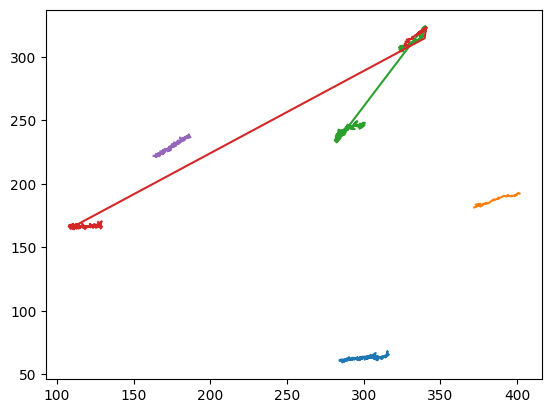

In [89]:
t = tracks_og
for item in t.rejoined_particle.unique(): # Loop for each sub trajectory
        x = t[t.rejoined_particle == item].x
        y = t[t.rejoined_particle == item].y
        plt.plot(x, y)
plt.show()

In [4]:
df_start = pd.DataFrame()
df_end = pd.DataFrame()
n_rejoined = 0
temp_tracks = tracks.copy()

# Get first and last point of each trajectory
for item in set(tracks.particle):

    subtrack = tracks[tracks.particle == item]
    df_temp = subtrack[subtrack.frame == np.min(subtrack.frame)]
    df_start = pd.concat((df_start, df_temp), ignore_index=True)

    df_temp = subtrack[subtrack.frame == np.max(subtrack.frame)]
    df_end = pd.concat((df_end, df_temp), ignore_index=True)

df_start = df_start.sort_values(by='frame', ascending=False)
df_end = df_end.sort_values(by='frame', ascending=False)

In [5]:
df_start

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,rejoined_particle,n_particles,n_static
2,3661,221.221267,250.785068,2210.0,2.209195,0.072827,186.0,2210.0,0.0,1316,10730,133.599992,10730,73,81
1,3445,128.522590,270.921687,664.0,2.591401,0.371132,80.0,664.0,0.0,665,5606,65.260578,67,73,81
5,3439,81.751174,311.563380,426.0,2.658144,0.143711,133.0,426.0,0.0,583,4823,9.879985,4823,73,81
0,2819,122.094007,227.655699,851.0,2.398345,0.773631,133.0,851.0,0.0,0,67,31.277308,67,73,81
3,396,302.815832,102.181745,3714.0,2.359515,0.146294,234.0,3714.0,0.0,0,45,230.003124,45,73,81
4,1054,321.297800,266.491881,3818.0,2.446012,0.144065,234.0,3818.0,0.0,0,46,28.128372,46,73,81
6,0,229.663939,283.397954,1955.0,1.977754,0.233723,207.0,1955.0,0.0,0,29,10.345836,29,73,81


In [6]:
df_end

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,rejoined_particle,n_particles,n_static
2,4052,205.874807,183.584544,3235.0,2.482022,0.135423,207.0,3235.0,0.0,1764,10730,133.599992,10730,73,81
4,2818,320.121072,236.756990,3469.0,2.396728,0.108906,234.0,3469.0,0.0,1764,46,28.128372,46,73,81
1,3660,133.555701,318.111402,763.0,2.081876,0.154434,159.0,763.0,0.0,888,5606,65.260578,67,73,81
3,1053,345.735178,182.318182,506.0,2.405938,0.330849,80.0,506.0,0.0,679,45,230.003124,45,73,81
0,3438,127.663417,257.725344,1744.0,2.209757,0.111411,207.0,1744.0,0.0,646,67,31.277308,67,73,81
5,3444,94.135678,328.000000,398.0,1.862079,0.343871,80.0,398.0,0.0,592,4823,9.879985,4823,73,81
6,395,222.236726,266.646018,452.0,1.971590,0.505435,80.0,452.0,0.0,427,29,10.345836,29,73,81


In [91]:
df_start = tracks.groupby(by="particle").agg({'frame':'min'}).sort_values(by='frame', ascending=False)
df_start

,frame
particle,
21573,2169
16022,1595
15999,1593
14477,1453
13787,1382
9824,992
9096,922


In [92]:
df_end = tracks.groupby(by="particle").agg({'frame':'max'}).sort_values(by='frame', ascending=False)
df_end

,frame
particle,
15999,2334
21573,2330
16022,1891
14477,1570
13787,1521
9096,1136
9824,1040


In [93]:
tstart = tracks.merge(df_start, on=['frame', 'particle'], how='right')
tstart

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,n_particles,n_static
0,1478,221.928375,163.073462,1089.0,2.659771,0.338894,160.0,1089.0,0.0,2169,21573,16.735924,82,82
1,1206,165.924731,110.215054,372.0,2.360062,0.158060,80.0,372.0,0.0,1595,16022,9.321026,82,82
2,496,323.779531,339.548705,4055.0,2.370857,0.042436,255.0,4055.0,0.0,1593,15999,16.687058,82,82
3,379,309.078261,328.539130,345.0,1.900419,0.452659,80.0,345.0,0.0,1453,14477,9.011286,82,82
4,250,244.713738,298.590944,1303.0,2.523565,0.158450,186.0,1303.0,0.0,1382,13787,12.474263,82,82
5,209,181.366337,372.102970,505.0,2.437740,0.609498,80.0,505.0,0.0,992,9824,22.494836,82,82
6,0,59.998433,287.125392,638.0,2.473369,0.106974,133.0,638.0,0.0,922,9096,26.873064,82,82


In [94]:
tend = tracks.merge(df_end, on=['frame', 'particle'], how='right')

In [95]:
joined = tend[['x', 'y', 'frame', 'particle']].merge(tstart[['x', 'y', 'frame', 'particle']],
                                                     how='cross')
joined


,x_x,y_x,frame_x,particle_x,x_y,y_y,frame_y,particle_y
0,324.235417,304.336458,2334,15999,163.073462,221.928375,2169,21573
1,324.235417,304.336458,2334,15999,110.215054,165.924731,1595,16022
2,324.235417,304.336458,2334,15999,339.548705,323.779531,1593,15999
3,324.235417,304.336458,2334,15999,328.539130,309.078261,1453,14477
4,324.235417,304.336458,2334,15999,298.590944,244.713738,1382,13787
5,324.235417,304.336458,2334,15999,372.102970,181.366337,992,9824
6,324.235417,304.336458,2334,15999,287.125392,59.998433,922,9096
7,187.004706,236.623529,2330,21573,163.073462,221.928375,2169,21573
8,187.004706,236.623529,2330,21573,110.215054,165.924731,1595,16022
9,187.004706,236.623529,2330,21573,339.548705,323.779531,1593,15999


In [96]:
joined['r_dist'] = np.sqrt((joined.x_x - joined.x_y)**2 + (joined.y_x - joined.y_y)**2)
joined['t_dist'] = joined.frame_y - joined.frame_x

In [103]:
filtered = joined.loc[(joined.t_dist > 0) & (joined.t_dist < 100)]

In [104]:
filtered

,x_x,y_x,frame_x,particle_x,x_y,y_y,frame_y,particle_y,r_dist,t_dist
22,339.748826,314.500000,1570,14477,110.215054,165.924731,1595,16022,273.423414,25
23,339.748826,314.500000,1570,14477,339.548705,323.779531,1593,15999,9.281689,23
29,282.210159,232.635458,1521,13787,110.215054,165.924731,1595,16022,184.479369,74
30,282.210159,232.635458,1521,13787,339.548705,323.779531,1593,15999,107.679854,72


In [105]:
filtered = filtered.loc[joined.r_dist < 400]

In [106]:
filtered

,x_x,y_x,frame_x,particle_x,x_y,y_y,frame_y,particle_y,r_dist,t_dist
22,339.748826,314.500000,1570,14477,110.215054,165.924731,1595,16022,273.423414,25
23,339.748826,314.500000,1570,14477,339.548705,323.779531,1593,15999,9.281689,23
29,282.210159,232.635458,1521,13787,110.215054,165.924731,1595,16022,184.479369,74
30,282.210159,232.635458,1521,13787,339.548705,323.779531,1593,15999,107.679854,72


In [107]:
filtered = filtered.sort_values(by=['t_dist', 'r_dist'])

In [108]:
filtered

,x_x,y_x,frame_x,particle_x,x_y,y_y,frame_y,particle_y,r_dist,t_dist
23,339.748826,314.500000,1570,14477,339.548705,323.779531,1593,15999,9.281689,23
22,339.748826,314.500000,1570,14477,110.215054,165.924731,1595,16022,273.423414,25
30,282.210159,232.635458,1521,13787,339.548705,323.779531,1593,15999,107.679854,72
29,282.210159,232.635458,1521,13787,110.215054,165.924731,1595,16022,184.479369,74


In [102]:
filtered = filtered.drop_duplicates('particle_y')
filtered

,x_x,y_x,frame_x,particle_x,x_y,y_y,frame_y,particle_y,r_dist,t_dist
23,339.748826,314.5,1570,14477,339.548705,323.779531,1593,15999,9.281689,23
22,339.748826,314.5,1570,14477,110.215054,165.924731,1595,16022,273.423414,25


In [18]:
tracks['rejoined_particle'] = tracks.particle

In [19]:
merged_df = tracks.merge(filtered[['particle_y', 'particle_x']], left_on='rejoined_particle', right_on='particle_y', how='left')
merged_df

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,n_particles,n_static,rejoined_particle,particle_y,particle_x
0,0,229.663939,283.397954,1955.0,1.977754,0.233723,207.0,1955.0,0.0,0,29,10.345836,73,81,29,NaN,NaN
1,1,229.538642,283.718970,2135.0,2.274592,0.167154,207.0,2135.0,0.0,1,29,10.345836,73,81,29,NaN,NaN
2,2,229.510138,284.151392,3699.0,2.387903,0.148729,234.0,3699.0,0.0,2,29,10.345836,73,81,29,NaN,NaN
3,3,230.049242,283.848485,1056.0,2.030543,0.355884,133.0,1056.0,0.0,3,29,10.345836,73,81,29,NaN,NaN
4,4,228.948768,283.964981,1542.0,1.917054,0.098045,133.0,1542.0,0.0,4,29,10.345836,73,81,29,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,4048,206.495546,183.496659,898.0,1.977884,0.283508,207.0,898.0,0.0,1760,10730,133.599992,73,81,10730,NaN,NaN
4049,4049,206.161555,182.981928,1826.0,2.121708,0.058722,207.0,1826.0,0.0,1761,10730,133.599992,73,81,10730,NaN,NaN
4050,4050,206.376982,183.427110,1955.0,2.176132,0.161288,186.0,1955.0,0.0,1762,10730,133.599992,73,81,10730,NaN,NaN
4051,4051,206.852459,183.196156,1769.0,2.103592,0.185307,234.0,1769.0,0.0,1763,10730,133.599992,73,81,10730,NaN,NaN


In [90]:
tracks['colA'] = merged_df['particle_x'].fillna(tracks['rejoined_particle'])

In [91]:
tracks

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,n_particles,n_static,rejoined_particle,colA
0,0,229.663939,283.397954,1955.0,1.977754,0.233723,207.0,1955.0,0.0,0,29,10.345836,73,81,29,29.0
1,1,229.538642,283.718970,2135.0,2.274592,0.167154,207.0,2135.0,0.0,1,29,10.345836,73,81,29,29.0
2,2,229.510138,284.151392,3699.0,2.387903,0.148729,234.0,3699.0,0.0,2,29,10.345836,73,81,29,29.0
3,3,230.049242,283.848485,1056.0,2.030543,0.355884,133.0,1056.0,0.0,3,29,10.345836,73,81,29,29.0
4,4,228.948768,283.964981,1542.0,1.917054,0.098045,133.0,1542.0,0.0,4,29,10.345836,73,81,29,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,4048,206.495546,183.496659,898.0,1.977884,0.283508,207.0,898.0,0.0,1760,10730,133.599992,73,81,10730,10730.0
4049,4049,206.161555,182.981928,1826.0,2.121708,0.058722,207.0,1826.0,0.0,1761,10730,133.599992,73,81,10730,10730.0
4050,4050,206.376982,183.427110,1955.0,2.176132,0.161288,186.0,1955.0,0.0,1762,10730,133.599992,73,81,10730,10730.0
4051,4051,206.852459,183.196156,1769.0,2.103592,0.185307,234.0,1769.0,0.0,1763,10730,133.599992,73,81,10730,10730.0


In [93]:
tracks.colA.unique()

array([   29.,    45.,    46.,    67.,  4823., 10730.])

In [94]:
tracks = tracks.drop('rejoined_particle', axis=1)
tracks.rename(columns={'colA': 'rejoined_particle'}, inplace=True)

In [96]:
tracks.rejoined_particle = tracks.rejoined_particle.astype(int)

In [97]:
tracks

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,n_particles,n_static,rejoined_particle
0,0,229.663939,283.397954,1955.0,1.977754,0.233723,207.0,1955.0,0.0,0,29,10.345836,73,81,29
1,1,229.538642,283.718970,2135.0,2.274592,0.167154,207.0,2135.0,0.0,1,29,10.345836,73,81,29
2,2,229.510138,284.151392,3699.0,2.387903,0.148729,234.0,3699.0,0.0,2,29,10.345836,73,81,29
3,3,230.049242,283.848485,1056.0,2.030543,0.355884,133.0,1056.0,0.0,3,29,10.345836,73,81,29
4,4,228.948768,283.964981,1542.0,1.917054,0.098045,133.0,1542.0,0.0,4,29,10.345836,73,81,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,4048,206.495546,183.496659,898.0,1.977884,0.283508,207.0,898.0,0.0,1760,10730,133.599992,73,81,10730
4049,4049,206.161555,182.981928,1826.0,2.121708,0.058722,207.0,1826.0,0.0,1761,10730,133.599992,73,81,10730
4050,4050,206.376982,183.427110,1955.0,2.176132,0.161288,186.0,1955.0,0.0,1762,10730,133.599992,73,81,10730
4051,4051,206.852459,183.196156,1769.0,2.103592,0.185307,234.0,1769.0,0.0,1763,10730,133.599992,73,81,10730


In [75]:
merged = tracks.merge(filtered[['particle_x','particle_y']], left_on='rejoined_particle', right_on='particle_y', how='left')
# merged = merged.drop('particle_x', axis=1)
merged

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,n_particles,n_static,rejoined_particle,particle_x,particle_y
0,0,229.663939,283.397954,1955.0,1.977754,0.233723,207.0,1955.0,0.0,0,29,10.345836,73,81,29,NaN,NaN
1,1,229.538642,283.718970,2135.0,2.274592,0.167154,207.0,2135.0,0.0,1,29,10.345836,73,81,29,NaN,NaN
2,2,229.510138,284.151392,3699.0,2.387903,0.148729,234.0,3699.0,0.0,2,29,10.345836,73,81,29,NaN,NaN
3,3,230.049242,283.848485,1056.0,2.030543,0.355884,133.0,1056.0,0.0,3,29,10.345836,73,81,29,NaN,NaN
4,4,228.948768,283.964981,1542.0,1.917054,0.098045,133.0,1542.0,0.0,4,29,10.345836,73,81,29,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,4048,206.495546,183.496659,898.0,1.977884,0.283508,207.0,898.0,0.0,1760,10730,133.599992,73,81,10730,NaN,NaN
4049,4049,206.161555,182.981928,1826.0,2.121708,0.058722,207.0,1826.0,0.0,1761,10730,133.599992,73,81,10730,NaN,NaN
4050,4050,206.376982,183.427110,1955.0,2.176132,0.161288,186.0,1955.0,0.0,1762,10730,133.599992,73,81,10730,NaN,NaN
4051,4051,206.852459,183.196156,1769.0,2.103592,0.185307,234.0,1769.0,0.0,1763,10730,133.599992,73,81,10730,NaN,NaN


In [67]:
merged.loc[merged.rejoined_particle==5606]

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,n_particles,n_static,rejoined_particle,particle_y
3445,3445,128.522590,270.921687,664.0,2.591401,0.371132,80.0,664.0,0.0,665,5606,65.260578,73,81,5606,5606.0
3446,3446,125.934783,269.471645,1058.0,2.441760,0.213681,127.0,1058.0,0.0,666,5606,65.260578,73,81,5606,5606.0
3447,3447,126.664564,269.553102,951.0,2.047799,0.189697,127.0,951.0,0.0,667,5606,65.260578,73,81,5606,5606.0
3448,3448,127.141577,270.882616,1116.0,2.304935,0.111809,106.0,1116.0,0.0,668,5606,65.260578,73,81,5606,5606.0
3449,3449,127.514870,270.930607,1614.0,2.422402,0.177811,160.0,1614.0,0.0,669,5606,65.260578,73,81,5606,5606.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,3656,134.705752,317.121681,452.0,2.881893,1.107031,106.0,452.0,0.0,882,5606,65.260578,73,81,5606,5606.0
3657,3657,134.726496,316.364103,585.0,2.374005,0.272261,80.0,585.0,0.0,883,5606,65.260578,73,81,5606,5606.0
3658,3658,135.628235,317.188235,425.0,1.919559,0.444065,106.0,425.0,0.0,884,5606,65.260578,73,81,5606,5606.0
3659,3659,133.145161,317.642473,372.0,1.337024,0.495263,106.0,372.0,0.0,886,5606,65.260578,73,81,5606,5606.0


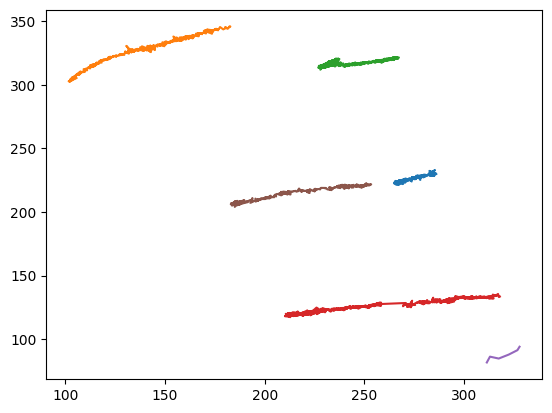

In [98]:
for item in tracks.rejoined_particle.unique(): # Loop for each sub trajectory
        x = tracks[tracks.rejoined_particle == item].x
        y = tracks[tracks.rejoined_particle == item].y
        plt.plot(x, y)
plt.show()

In [49]:
merged.particle.unique()

array([   29,    45,    46,    67,  4823,  5606, 10730])

In [50]:
merged.rejoined_particle.unique()

array([   29,    45,    46,    67,  4823,  5606, 10730])

In [18]:
for p in merged.particle.unique():
    print(p)
    print(len(merged.loc[merged.particle==p]))

29
396
45
658
46
1765
67
620
4823
6
5606
216
10730
392


In [19]:
for p in merged.rejoined_particle.unique():
    print(p)
    print(len(merged.loc[merged.rejoined_particle==p]))

29
396
45
658
46
1765
67
836
4823
6
10730
392


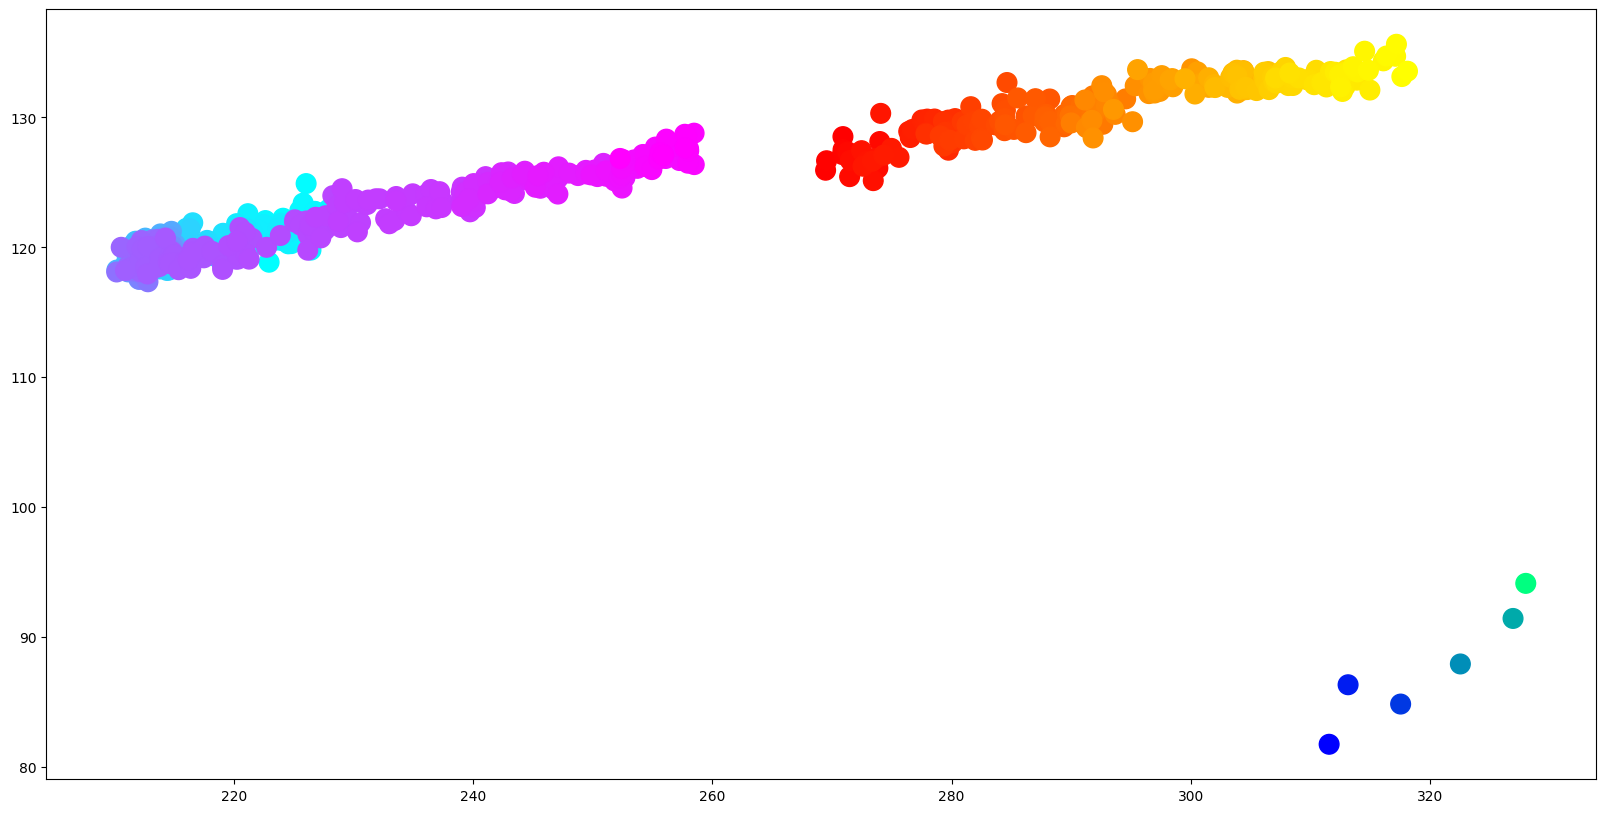

In [63]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
t67 = tracks.loc[tracks.particle==67]
t5606 = tracks.loc[tracks.particle==5606]
t4823 = tracks.loc[tracks.particle==4823]
ax1.scatter(t67.x, t67.y,c=t67.frame, cmap='cool',s=200)
ax1.scatter(t5606.x, t5606.y,c=t5606.frame, cmap='autumn',s=200)
ax1.scatter(t4823.x, t4823.y,c=t4823.frame, cmap='winter',s=200)
# fig.colorbar(t, ax=ax1)
plt.show()

In [41]:
tracks = tracks.drop('rejoined_particle', axis=1)

In [42]:
rej123, p = rejoining(tracks=tracks, threshold_t=100, threshold_r=400)

In [43]:
rej123

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,n_particles,n_static,rejoined_particle
0,0,229.663939,283.397954,1955.0,1.977754,0.233723,207.0,1955.0,0.0,0,29,10.345836,73,81,29
1,1,229.538642,283.718970,2135.0,2.274592,0.167154,207.0,2135.0,0.0,1,29,10.345836,73,81,29
2,2,229.510138,284.151392,3699.0,2.387903,0.148729,234.0,3699.0,0.0,2,29,10.345836,73,81,29
3,3,230.049242,283.848485,1056.0,2.030543,0.355884,133.0,1056.0,0.0,3,29,10.345836,73,81,29
4,4,228.948768,283.964981,1542.0,1.917054,0.098045,133.0,1542.0,0.0,4,29,10.345836,73,81,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,4048,206.495546,183.496659,898.0,1.977884,0.283508,207.0,898.0,0.0,1760,10730,133.599992,73,81,10730
4049,4049,206.161555,182.981928,1826.0,2.121708,0.058722,207.0,1826.0,0.0,1761,10730,133.599992,73,81,10730
4050,4050,206.376982,183.427110,1955.0,2.176132,0.161288,186.0,1955.0,0.0,1762,10730,133.599992,73,81,10730
4051,4051,206.852459,183.196156,1769.0,2.103592,0.185307,234.0,1769.0,0.0,1763,10730,133.599992,73,81,10730


In [34]:
p

1

In [35]:
rej123.particle.unique()

array([   29,    45,    46,    67,  4823,  5606, 10730])

In [44]:
rej123.rejoined_particle.unique()

array([   29,    45,    46,    67,  4823, 10730])

In [55]:
for p in rej123.particle.unique():
    print(p)
    print(len(rej123.loc[rej123.particle==p]))

29
396
45
658
46
1765
67
620
4823
6
5606
216
10730
392


In [53]:
for p in rej123.rejoined_particle.unique():
    print(p)
    print(len(rej123.loc[rej123.rejoined_particle==p]))

29
396
45
658
46
1765
67
836
4823
6
10730
392


In [1]:
from pathlib import Path

In [1]:
input_folder = (r'/media/lumin/DATA/Demo_BioProbe')
extension = '.tif'

In [21]:
path_list = Path(input_folder).glob(f'**/*{extension}')
path_list

<generator object Path.glob at 0x731f58732ac0>

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np

In [5]:
data = {'A':[1,2,3,4,5,6,7,8],
        'B':[1,2,3,4,5,6,7,8],
        'C':[1,2,3,4,5,6,7,8],
        'D':[1,2,3,4,5,6,7,8],
        'E':[1,2,3,4,5,6,7,8],
        'F':[1,2,3,4,5,6,7,8],
        'G':[1,2,3,4,5,6,7,8],
        'H':[1,2,3,4,5,6,7,8],}

In [6]:
data = pd.DataFrame(data)

In [27]:
data = pd.read_csv(r'/media/lumin/DATA/20240518_024225_trajectory_parameters.csv', sep='\t')

In [30]:
gfp_pos = data.loc[data['gfp'] == "[ True]"]
data = gfp_pos

In [32]:
data = data.drop_duplicates(subset='file')

In [18]:
data = data.dropna()

In [34]:
data['fraction_moving'] = data['fraction_moving'].dropna()

/tmp/ipykernel_408804/970204565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fraction_moving'] = data['fraction_moving'].dropna()


In [35]:
data.loc[data.condition=='C1'].fraction_moving

72     0.285714
75     0.600000
81     0.222222
93     0.666667
229    0.357143
232    0.111111
273    0.166667
Name: fraction_moving, dtype: float64

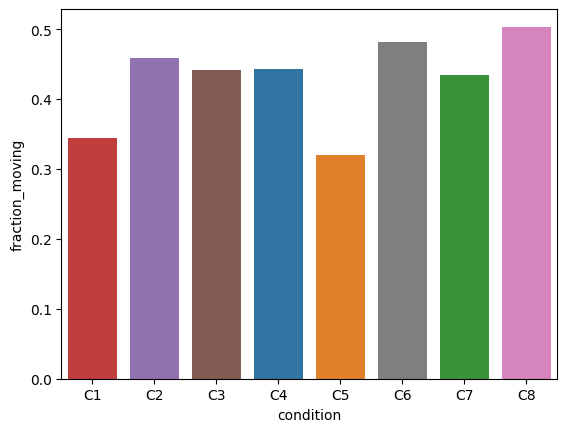

In [36]:
bars = sns.barplot(data=data, y='fraction_moving', x='condition', estimator=np.mean,
                       errorbar=None, hue='condition', order=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'],
                       err_kws={'elinewidth': 2, 'capsize': 4, 'capthick': 2})

In [1]:
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [30]:
img = imread(r'/media/lumin/DATA/test_48.tif')

/tmp/ipykernel_419413/798005766.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(r'/media/lumin/DATA/test_48.tif')


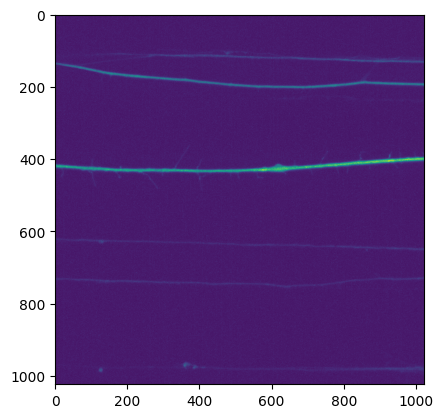

In [31]:
plt.imshow(img)

In [36]:
threshold = 110
mask = img.copy()
mask[mask >= threshold] = 4096
mask[mask < threshold] = 0
np.mean(mask)

778.8359375

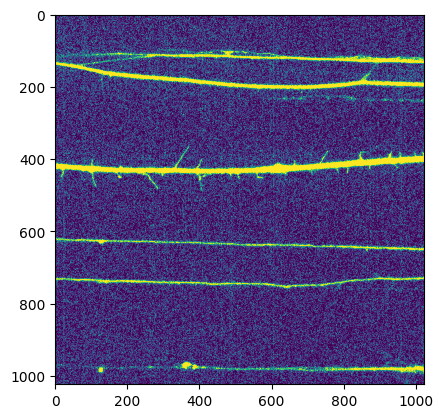

In [37]:
plt.imshow(mask)

In [ ]:

threshold = 120
mask = img
mask[mask >= threshold] = 4096
mask[mask < threshold] = 0

mask_list = []

for x, y in zip(trajectories.x, trajectories.y):
    if mask[int(y), int(x)] == 4096:
        mask_list.append('in')
    else:
        mask_list.append('out')

trajectories['GFP_mask'] = mask_list

ratio_list = []
streak_list = []

df = pd.DataFrame()

for traj in trajectories.rejoined_particle.unique():
    traj = trajectories[trajectories.rejoined_particle == traj]
    ratio = len(traj[traj.GFP_mask == 'in'])/len(traj)
    ratio = [ratio]*len(traj)
    ratio_list.extend(ratio)
    ratio = pd.DataFrame(ratio, columns=['ratio_df'])
    traj['ratio_df'] = ratio.values
    streak = longest_streak(list(traj.GFP_mask))
    streak = [streak]*len(traj)
    streak = pd.DataFrame(streak, columns=['streak_df'])
    streak_list.extend(streak)
    df = pd.concat((df, traj))

    # trajectories['ratio'] = ratio_list
    # trajectories['streak'] = streak_list